## Quickstart

In this section, users will learn

1. the data input required to create a basic MMM
2. the fit and predict process of MMM
2. basic usage of the MMM

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import karpiu
from karpiu.models import MMM

pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_rows', 50)

print(karpiu.__version__)

0.0.1


In [2]:
%load_ext autoreload
%autoreload 2

### Data Input

In [3]:
RAW_DATA_FILE = 'data.csv'
SCALABILITY_FILE = 'scalability_df.csv'
ADSTOCK_FILE = 'adstock.csv'

paid_channels = ['tv', 'radio', 'social', 'promo', 'search']

This is the core spend and response(the sales) input data.

In [4]:
df = pd.read_csv(RAW_DATA_FILE, parse_dates=['date'])
df.head(5)

,date,sales,tv,radio,social,promo,search
0,2019-01-01,498.00000,9998.00000,4176.00000,0.00000,0.00000,992.00000
1,2019-01-02,726.00000,13805.00000,0.00000,3541.00000,0.00000,1039.00000
2,2019-01-03,736.00000,9549.00000,0.00000,4143.00000,1156.00000,419.00000
3,2019-01-04,655.00000,15083.00000,8102.00000,2176.00000,2011.00000,659.00000
4,2019-01-05,319.00000,0.00000,0.00000,2873.00000,1189.00000,0.00000


In [5]:
scalability_df = pd.read_csv(SCALABILITY_FILE)
scalability_df.head(5)

,regressor,scalability
0,tv,1.10000
1,radio,0.75000
2,social,1.30000
3,promo,1.50000
4,search,0.90000


Make sure they are sorted and with the regressor name as the index

In [6]:
adstock_df = pd.read_csv(ADSTOCK_FILE)
adstock_df = adstock_df.sort_values(by=['regressor'])
adstock_df = adstock_df.set_index('regressor')
print(adstock_df)

               d0      d1      d2      d3
regressor                                
promo     0.80000 0.20000 0.00000 0.00000
radio     0.60000 0.20000 0.10000 0.10000
search    1.00000 0.00000 0.00000 0.00000
social    0.70000 0.20000 0.10000 0.00000
tv        0.50000 0.20000 0.20000 0.10000


### Fitting a Basic MMM

In [7]:
mmm = MMM(
    kpi_col='sales',
    date_col='date', 
    spend_cols=paid_channels,
    scalability_df=scalability_df,
    event_cols=[],
    seed=2022,
    adstock_df=adstock_df,
)

2023-01-22 18:19:23 - karpiu-mmm - INFO - Initialize model


For now, users can skip the hyper-parameters fitting section and directly set some prepared hyper-parameters.

In [8]:
best_params = {
    'damped_factor': 0.949,
    'level_sm_input': 0.0245,
    'slope_sm_input': 0.0943,
 }
mmm.set_hyper_params(best_params)
mmm.best_params

2023-01-22 18:19:23 - karpiu-mmm - INFO - Set hyper-parameters.
2023-01-22 18:19:23 - karpiu-mmm - INFO - Best params damped_factor set as 0.94900
2023-01-22 18:19:23 - karpiu-mmm - INFO - Best params level_sm_input set as 0.02450
2023-01-22 18:19:23 - karpiu-mmm - INFO - Best params slope_sm_input set as 0.09430


{'damped_factor': 0.949, 'level_sm_input': 0.0245, 'slope_sm_input': 0.0943}

Fit the model with supplied dataframe.

In [9]:
mmm.fit(df)

2023-01-22 18:19:23 - karpiu-mmm - INFO - Fit final model.
2023-01-22 18:19:23 - karpiu-mmm - INFO - Deriving saturation constants...
2023-01-22 18:19:23 - karpiu-mmm - INFO - Derived saturation constants.
2023-01-22 18:19:23 - karpiu-mmm - INFO - Build a default regression scheme
2023-01-22 18:19:23 - orbit - INFO - Sampling (PyStan) with chains: 1, cores: 8, temperature: 1.000, warmups (per chain): 400 and samples(per chain): 100.
2023-01-22 18:19:23 - orbit - INFO - First time in running stan model:dlt. Expect 3 - 5 minutes for compilation.


chain 1 |          | 00:00 Status

2023-01-22 18:19:51 - karpiu-mmm - INFO - Spend channels regression coefficients sum (0.26889095) is within common range (0, 0.8].


### Extracting Insights from the Model

### Attribution

In [10]:
from karpiu.explainability import Attributor

In [11]:
ATTR_START = '2019-03-01'
ATTR_END = '2019-03-31'
attributor = Attributor(model=mmm, start=ATTR_START, end=ATTR_END)
activities_attr_df, spend_attr_df, spend_df, cost_df = attributor.make_attribution()

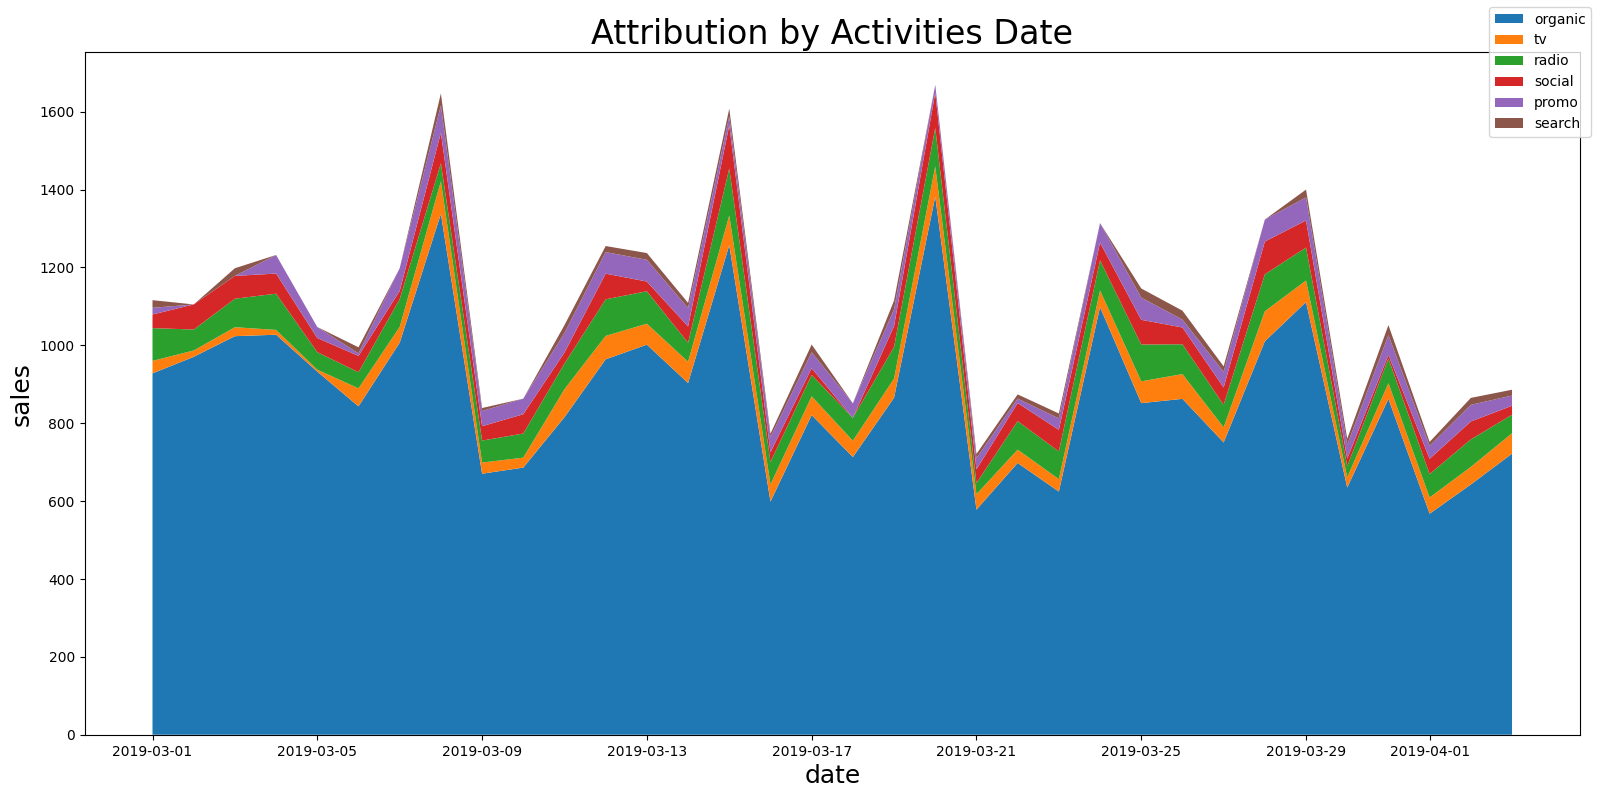

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.stackplot(
    activities_attr_df['date'].values, 
    activities_attr_df[['organic'] + paid_channels].values.transpose(), 
    labels=['organic'] + paid_channels
)
ax.set_title("Attribution by Activities Date", fontdict={'fontsize': 24})
ax.set_xlabel("date", fontdict={'fontsize': 18})
ax.set_ylabel("sales", fontdict={'fontsize': 18})
fig.legend()
fig.tight_layout();

### Cost and Efficiency Analysis

In [13]:
from karpiu.planning import CostCurves

In [14]:
cc = CostCurves(
    model=mmm,
    curve_type='individual',
    n_steps=50,
    channels=paid_channels,
    spend_start=ATTR_START, 
    spend_end=ATTR_END,
)
cc.generate_cost_curves()

  0%|          | 0/5 [00:00<?, ?it/s]

In [15]:
cc.plot()

array([<AxesSubplot: title={'center': 'radio'}, xlabel='spend', ylabel='signups'>,
       <AxesSubplot: title={'center': 'tv'}, xlabel='spend', ylabel='signups'>,
       <AxesSubplot: title={'center': 'search'}, xlabel='spend', ylabel='signups'>,
       <AxesSubplot: title={'center': 'social'}, xlabel='spend', ylabel='signups'>,
       <AxesSubplot: title={'center': 'promo'}, xlabel='spend', ylabel='signups'>,
       <AxesSubplot: >], dtype=object)

### Model Regression Coefficents

In [16]:
mmm.get_regression_summary()

,regressor,sign,coef_p50,coef_p05,coef_p95,Pr(coef >= 0),Pr(coef < 0),loc_prior,scale_prior
0,promo,Positive,0.05461,0.01580,0.07728,1.00000,0.00000,0.00000,0.10000
1,radio,Positive,0.07743,0.04851,0.10488,1.00000,0.00000,0.00000,0.10000
2,search,Positive,0.01260,0.00237,0.03972,1.00000,0.00000,0.00000,0.10000
3,social,Positive,0.06609,0.02688,0.10252,1.00000,0.00000,0.00000,0.10000
4,tv,Positive,0.05815,0.02243,0.09601,1.00000,0.00000,0.00000,0.10000


## Dump Model for Future Usage

In [18]:
import pickle
with open("./resource/model.pkl", 'wb') as f:
    pickle.dump(mmm, f, protocol=pickle.HIGHEST_PROTOCOL)